🧹 Sau khi làm sạch & loại trùng:
- Việt: 95,847 câu
- Lào : 93,355 câu
- Tổng : 148,404 câu

🔍 Số câu trùng giữa TRAIN/TEST: 0 (0.00%)

🔁 Tải lại mô hình & vectorizer...

🎯 Độ chính xác Test: 0.9995

📋 Báo cáo phân loại:
              precision    recall  f1-score   support

          lo       1.00      1.00      1.00      7197
          vi       1.00      1.00      1.00      7644

    accuracy                           1.00     14841
   macro avg       1.00      1.00      1.00     14841
weighted avg       1.00      1.00      1.00     14841


❌ Các câu bị đoán sai:
- Câu: trumpoline Donal ເກມ trump
 Thực tế: lo → Dự đoán: vi

- Câu: RN WHNP
 Thực tế: lo → Dự đoán: vi

- Câu: r n ssJsn
 Thực tế: lo → Dự đoán: vi

- Câu: س ͧ ǹ ŧ ŧ շͧ ͺ ͺ س ͧ ֧ ͧອ ç
 Thực tế: lo → Dự đoán: vi

- Câu: ງາມຫນ້າ http www mobilecasinofun com keep win casino no deposit bonus
 Thực tế: lo → Dự đoán: vi

- Câu: R n
 Thực tế: lo → Dự đoán: vi

- Câu: USB C ກັບ USB B
 Thực tế: vi → Dự đoán: lo



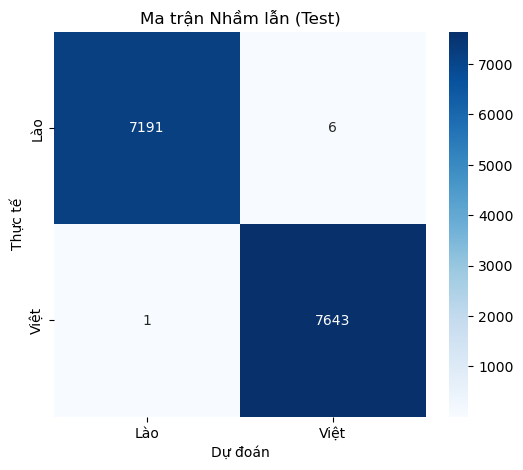

In [3]:
import os
import re
import unicodedata
import pandas as pd
import joblib
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

# --- 1️⃣ ĐƯỜNG DẪN DỮ LIỆU ---
# CHÚ Ý: Đường dẫn cần được chỉnh lại cho môi trường thực tế của bạn
vi_file = "C:/Users/CHIENQT/Downloads/Vietnamese_Lao/VLSP2023/Train/train2023.vi"
lo_file = "C:/Users/CHIENQT/Downloads/Vietnamese_Lao/VLSP2023/Train/train2023.lo"

# --- 2️⃣ ĐƯỜNG DẪN LƯU MÔ HÌNH ---
MODEL_PATH = "logistic_vi_lo_modelv8.joblib"
VECTORIZER_PATH = "tfidf_vectorizer_vi_lov8.joblib"

# --- 🧹 HÀM LÀM SẠCH ---
def clean_text(text):
    text = unicodedata.normalize("NFC", text)
    
    # Giữ lại chữ cái Latin (A-Za-z), chữ cái tiếng Việt (À-ỹ), chữ cái tiếng Lào (ກ-ຮເ-ໄົ-ຽ) và khoảng trắng
    text = re.sub(r"[^A-Za-zÀ-ỹກ-ຮເ-ໄົ-ຽ\s]", " ", text)
    
    text = re.sub(r"\s+", " ", text).strip()

    # Sửa lỗi Syntax/Logic: Đưa câu lệnh điều kiện vào trong hàm clean_text
    if len(text.split()) < 2 or len(text.split()) > 100:
        return None
        
    return text

# --- 💡 HÀM TÍNH TỶ LỆ KÝ TỰ ---
def char_ratio(text):
    total = len(text)
    
    if total == 0:
        return 0.0, 0.0
        
    latin = len(re.findall(r"[A-Za-zÀ-ỹ]", text)) # Latin và Việt
    lao = len(re.findall(r"[\u0E80-\u0EDF]", text)) # Ký tự Lào (Unicode range)
    
    return latin / total, lao / total

# --- 3️⃣ HÀM ĐỌC DỮ LIỆU ---
def load_and_label_data(file_path, label):
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file tại đường dẫn: {file_path}")
        return pd.DataFrame({"text": [], "label": []})

    cleaned = []
    for line in lines:
        c = clean_text(line)
        if c:
            cleaned.append(c)

    return pd.DataFrame({"text": cleaned, "label": [label]*len(cleaned)})

# --- 4️⃣ LOAD & LÀM SẠCH ---
df_vi = load_and_label_data(vi_file, "vi")
df_lo = load_and_label_data(lo_file, "lo")

# Kiểm tra nếu một trong hai dataframe rỗng (do lỗi File Not Found)
if df_vi.empty or df_lo.empty:
    print("Không đủ dữ liệu để tiếp tục. Vui lòng kiểm tra đường dẫn file.")
    exit()

df = pd.concat([df_vi, df_lo]).drop_duplicates(subset=["text"]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"🧹 Sau khi làm sạch & loại trùng:")
print(f"- Việt: {len(df_vi):,} câu")
print(f"- Lào : {len(df_lo):,} câu")
print(f"- Tổng : {len(df):,} câu")

# --- 5️⃣ CHIA DỮ LIỆU ---
X = df["text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Kiểm tra trùng
train_set = set(X_train)
test_set = set(X_test)
overlap = train_set.intersection(test_set)
print(f"\n🔍 Số câu trùng giữa TRAIN/TEST: {len(overlap)} ({len(overlap)/len(X_test)*100:.2f}%)")

# --- 6️⃣ HUẤN LUYỆN HOẶC TẢI LẠI ---
if os.path.exists(MODEL_PATH) and os.path.exists(VECTORIZER_PATH):
    print("\n🔁 Tải lại mô hình & vectorizer...")
    lr_model = joblib.load(MODEL_PATH)
    vectorizer = joblib.load(VECTORIZER_PATH)
else:
    print("\n🚀 Huấn luyện mới...")
    vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=4)
    X_train_vec = vectorizer.fit_transform(X_train)

    # ➕ Thêm đặc trưng tỷ lệ ký tự
    ratios_train = np.array([char_ratio(t) for t in X_train])
    X_train_full = hstack([X_train_vec, ratios_train])

    lr_model = LogisticRegression(solver="saga", C=0.5, random_state=42, max_iter=1000, n_jobs=-1)
    lr_model.fit(X_train_full, y_train)

    joblib.dump(lr_model, MODEL_PATH)
    joblib.dump(vectorizer, VECTORIZER_PATH)
    print(f"💾 Lưu mô hình vào: {MODEL_PATH}")
    print(f"💾 Lưu vectorizer vào: {VECTORIZER_PATH}")

# --- 7️⃣ ĐÁNH GIÁ ---
# Cần đảm bảo vectorizer đã được fit (hoặc load) trước khi gọi transform
if 'vectorizer' not in locals(): # Kiểm tra nếu vectorizer chưa được tạo/tải
    print("\nLỗi: Không tìm thấy vectorizer. Vui lòng kiểm tra lại đường dẫn file hoặc chạy huấn luyện.")
    exit()

X_test_vec = vectorizer.transform(X_test)
ratios_test = np.array([char_ratio(t) for t in X_test])
X_test_full = hstack([X_test_vec, ratios_test])

y_pred = lr_model.predict(X_test_full)

acc = accuracy_score(y_test, y_pred)
print("\n" + "="*60)
print(f"🎯 Độ chính xác Test: {acc:.4f}")
print("="*60)
print("\n📋 Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

# --- ❌ IN CÂU SAI ---
errors = pd.DataFrame({"text": X_test, "true_label": y_test, "pred_label": y_pred})
errors = errors[errors["true_label"] != errors["pred_label"]]
print("\n❌ Các câu bị đoán sai:")
# Giới hạn số lượng câu in ra để tránh output quá dài
for i, r in errors.head(10).iterrows(): 
    print(f"- Câu: {r['text']}")
    print(f" Thực tế: {r['true_label']} → Dự đoán: {r['pred_label']}\n")
if len(errors) > 10:
    print(f"... và {len(errors) - 10} câu sai khác.")

# --- 8️⃣ MA TRẬN NHẦM LẪN ---
cm = confusion_matrix(y_test, y_pred, labels=["lo", "vi"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Lào","Việt"], yticklabels=["Lào","Việt"])
plt.title("Ma trận Nhầm lẫn (Test)")
plt.ylabel("Thực tế")
plt.xlabel("Dự đoán")
plt.show()